# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [3]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Connect to DB, load data, clean data

In [4]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [5]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT 
        package_id, 
        from_id, 
        to_id, 
        (from_semver).major AS from_semver_major, 
        (from_semver).minor AS from_semver_minor, 
        (from_semver).bug AS from_semver_bug,
        (to_semver).major AS to_semver_major, 
        (to_semver).minor AS to_semver_minor, 
        (to_semver).bug AS to_semver_bug,
        from_created,
        to_created,
        ty,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM analysis.vuln_intro_updates) as did_intro_vuln,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM analysis.vuln_patch_updates) as did_patch_vuln
    FROM analysis.all_updates
")

In [6]:
all_updates_sub <- all_updates[sample(nrow(all_updates), 100000),] 

In [7]:
all_updates <- all_updates %>% filter(ty != "zero_to_something")

In [8]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- factor(all_updates$ty, levels=c("bug", "minor", "major"))

In [9]:
head(all_updates)

,package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
1,871385,4555319,4555320,0,7,3,1,0,0,2019-08-10 15:37:04,2020-07-06 20:52:19,major,FALSE,FALSE,major
2,871385,4555345,4555346,1,1,1,2,0,0,2020-10-31 21:40:19,2021-06-06 21:52:47,major,FALSE,FALSE,major
3,871386,4555378,4555380,0,6,8,0,7,1,2019-05-04 15:58:09,2019-07-17 05:47:03,minor,FALSE,FALSE,minor
4,871386,4555385,4555386,0,7,2,1,0,0,2019-07-20 22:34:04,2020-07-06 20:52:16,major,FALSE,FALSE,major
5,871387,4555438,4555439,0,0,1,0,0,2,2017-10-01 02:44:21,2017-10-01 02:46:27,bug,FALSE,FALSE,bug
6,871387,4555440,4555441,0,0,3,0,0,4,2017-10-01 20:51:49,2017-10-01 21:31:14,bug,FALSE,FALSE,bug


In [10]:
patches_only <- all_updates %>% filter(did_patch_vuln == TRUE & did_intro_vuln == FALSE)
others <- all_updates %>% filter(did_patch_vuln == FALSE | did_intro_vuln == TRUE)

# select the row with ty ordered bug,minor,major for each from_id
patches_lowest_type <- patches_only %>% group_by(from_id) %>% top_n(-1, tyFact)
patches_first_created <- patches_only %>% group_by(from_id) %>% top_n(-1, to_created)

In [11]:
patches_only

package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
1007773,5765032,5765033,0,1,0,1,0,0,2018-07-22 13:59:13,2019-01-31 08:06:00,major,FALSE,TRUE,major
1043252,6133139,6133140,0,5,0,0,6,0,2017-03-04 19:32:51,2017-03-05 00:30:01,minor,FALSE,TRUE,minor
1067473,6377114,6377115,0,3,0,0,4,0,2019-09-20 13:52:46,2020-03-01 10:01:50,minor,FALSE,TRUE,minor
1118882,6759219,6759220,0,2,0,0,3,0,2018-11-30 22:40:49,2019-06-21 12:03:39,minor,FALSE,TRUE,minor
1204278,7447118,7447119,0,25,1,0,26,0,2021-07-04 04:50:38,2022-02-07 06:18:29,minor,FALSE,TRUE,minor
1222574,7601720,7601721,3,0,0,4,0,0,2020-10-11 20:48:29,2021-02-10 23:10:11,major,FALSE,TRUE,major
1253403,7853032,7853033,0,9,0,0,10,0,2021-09-02 07:34:04,2021-11-14 00:33:42,minor,FALSE,TRUE,minor
1444122,9282043,9282044,0,2,0,0,3,0,2021-01-30 20:43:36,2021-03-31 19:07:06,minor,FALSE,TRUE,minor
1470637,9525328,9525329,0,32,0,0,33,0,2019-06-13 10:28:40,2020-11-07 09:11:40,minor,FALSE,TRUE,minor


# Make plots!

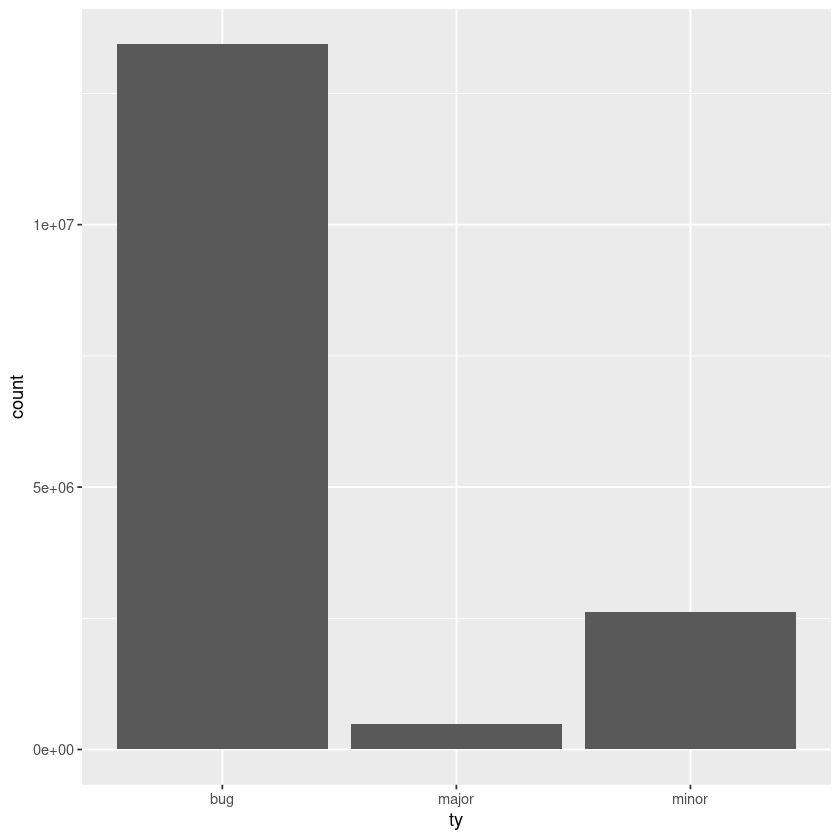

In [12]:
# Takes about 20 seconds
ggplot(data = all_updates, aes(x = ty)) +
    geom_bar()

### What proportion of each package's update are each type?

In [13]:
# creates a data frame with one row per package, and columns for count of each update type
updateCountsByPackage <- all_updates %>%
    group_by(package_id,did_intro_vuln,did_patch_vuln,tyFact) %>%
    summarise(
        count = n()
    ) %>% 
    pivot_wider(names_from = tyFact, values_from = count, values_fill=0) %>%
    mutate(total = bug + minor + major,
           bugPct = bug / total,
           majorPct = major / total,
           minorPct = minor / total,
    ) %>%
    mutate(update_action = ifelse(did_intro_vuln, 'Intro vuln', ifelse(did_patch_vuln, 'Patch vuln', 'No security effect')))

`summarise()` has grouped output by 'package_id', 'did_intro_vuln',
'did_patch_vuln'. You can override using the `.groups` argument.


In [14]:
head(updateCountsByPackage)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,bugPct,majorPct,minorPct,update_action
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
335,FALSE,FALSE,150,182,12,344,0.4360465,0.03488372,0.5290698,No security effect
336,FALSE,FALSE,2,0,0,2,1.0000000,0.00000000,0.0000000,No security effect
337,FALSE,FALSE,1,0,0,1,1.0000000,0.00000000,0.0000000,No security effect
341,FALSE,FALSE,384,233,18,635,0.6047244,0.02834646,0.3669291,No security effect
488,FALSE,FALSE,1,0,1,2,0.5000000,0.50000000,0.0000000,No security effect
2580,FALSE,FALSE,2,1,0,3,0.6666667,0.00000000,0.3333333,No security effect


In [15]:
# make a long version of it for ggplot
updateCountsByPackageLong <- updateCountsByPackage %>%
    pivot_longer(cols=ends_with("Pct"), names_to="ty", values_to="pct")

In [16]:
updateCountsByPackageLong$update_action <- factor(updateCountsByPackageLong$update_action, levels=c('No security effect', 'Intro vuln', 'Patch vuln'))
updateCountsByPackageLong$ty <- recode(updateCountsByPackageLong$ty, bugPct='Bug', minorPct='Minor', majorPct='Major')
updateCountsByPackageLong$ty <- factor(updateCountsByPackageLong$ty, levels=c('Bug', 'Minor', 'Major'))

In [17]:
head(updateCountsByPackageLong)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,update_action,ty,pct
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
335,FALSE,FALSE,150,182,12,344,No security effect,Bug,0.43604651
335,FALSE,FALSE,150,182,12,344,No security effect,Major,0.03488372
335,FALSE,FALSE,150,182,12,344,No security effect,Minor,0.52906977
336,FALSE,FALSE,2,0,0,2,No security effect,Bug,1.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Major,0.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Minor,0.00000000


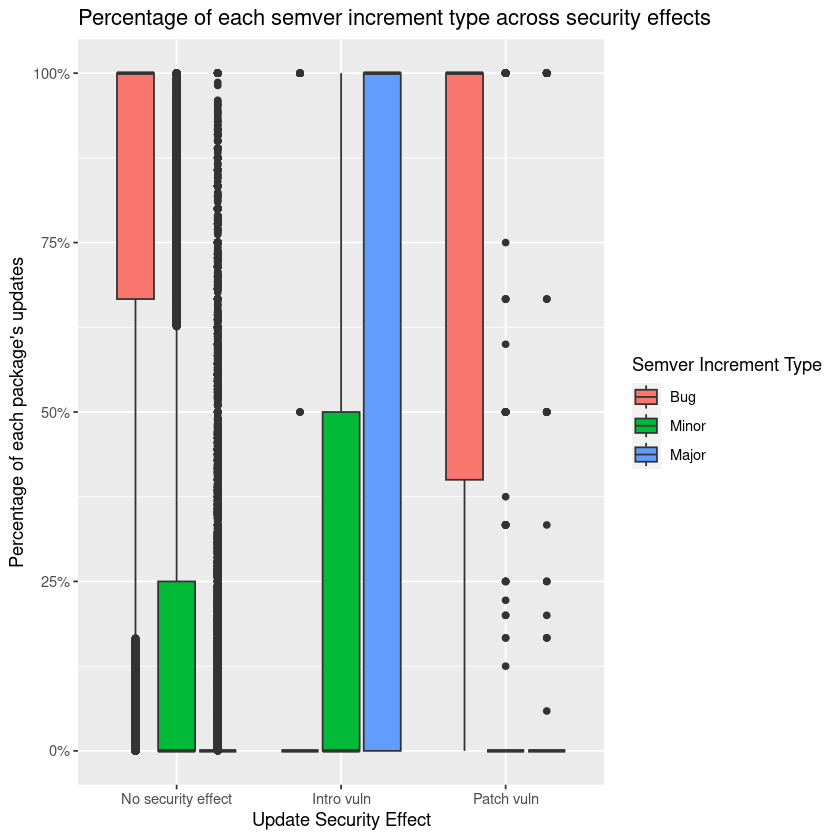

In [18]:
# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = update_action, y = pct, fill=ty)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(title = "Percentage of each semver increment type across security effects", fill='Semver Increment Type', x='Update Security Effect', y = 'Percentage of each package\'s updates')